In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.metrics import r2_score

In [74]:
df=pd.read_csv("data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

PoolQC       1453
MiscFeature       1406
Alley       1369
Fence       1179
MasVnrType       872
FireplaceQu       690
LotFrontage       259
GarageType       81
GarageYrBlt       81
GarageFinish       81
GarageQual       81
GarageCond       81
BsmtExposure       38
BsmtFinType2       38
BsmtQual       37
BsmtCond       37
BsmtFinType1       37
MasVnrArea       8
Electrical       1


<Axes: >

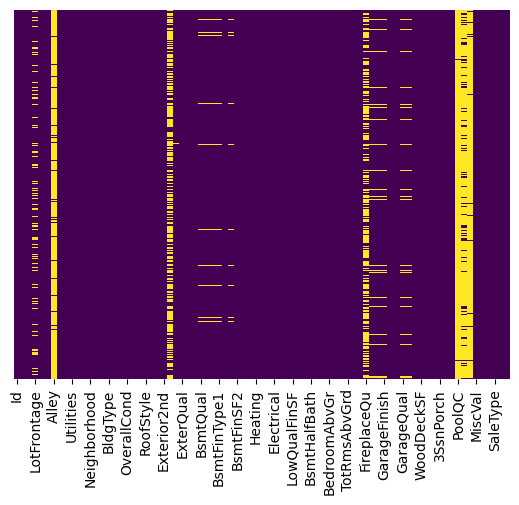

In [75]:
na_count=[]
for column in df.columns:
    na_count.append((column,np.count_nonzero(df[column].isnull())))
na_count.sort(key=lambda x:x[1],reverse=True)
for i in na_count:
    if i[1]==0:break
    print(i[0],'     ',i[1])

sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [76]:
def preproc_x_train(x:pd.DataFrame,num_fillna,num_scaler:StandardScaler,obj_formater:OneHotEncoder,pca_n_components:int):

    x_num=x.select_dtypes(['float64','int64'])
    x_num=x_num.fillna(num_fillna(x_num))

    x_obj=x.select_dtypes(['object'])

    x_num_scaled=pd.DataFrame(data=num_scaler.fit_transform(x_num),columns=x_num.columns)


    onehotencoder = obj_formater
    obj_df_encode = onehotencoder.fit_transform(x_obj)

    encode_columns=[]
    for column, postfixes in zip(x_obj.columns,onehotencoder.categories_):
        for postfix in postfixes:
            encode_columns.append(str(column+'_'+str(postfix).replace(' ','_')))

    x_obj_formated=pd.DataFrame(obj_df_encode.toarray(),columns=encode_columns)

    x_train=pd.concat([x_num_scaled,x_obj_formated], axis=1)
    pca_formater=PCA(n_components=pca_n_components)
    if pca_n_components>0:
        x_train=pd.DataFrame(pca_formater.fit_transform(x_train))
    

    return x_train,num_scaler, obj_formater, pca_formater,encode_columns



def preproc_x_test(x:pd.DataFrame,num_fillna,num_scaler:StandardScaler,obj_formater:OneHotEncoder,pca_formater:PCA,encode_columns):

    x_num=x.select_dtypes(['float64','int64'])
    x_num=x_num.fillna(num_fillna(x_num))

    x_obj=x.select_dtypes(['object'])

    x_num_scaled=pd.DataFrame(data=num_scaler.transform(x_num),columns=x_num.columns)


    onehotencoder = obj_formater
    obj_df_encode = onehotencoder.transform(x_obj)

    x_obj_formated=pd.DataFrame(obj_df_encode.toarray(),columns=encode_columns)

    x_test=pd.concat([x_num_scaled,x_obj_formated], axis=1)

    try:
        if pca_formater.n_components_>0:
            x_test=pd.DataFrame(pca_formater.transform(x_test))
    except:
        pass

    return x_test


def preprocess_y_train(y:pd.DataFrame,y_scaler:StandardScaler):
    y_test=pd.DataFrame(y_scaler.fit_transform(y), columns=['SalePrice'])
    return y_test,y_scaler
    

In [77]:
y=df['SalePrice']
x=df.drop(columns=['SalePrice','Id'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

num_fillna=lambda x:0
num_scaler=MinMaxScaler()
obj_formater=OneHotEncoder(handle_unknown='infrequent_if_exist')
pca_n_components=0
y_scaler=MinMaxScaler()

x_train_formated,num_scaler,obj_formater,pca_formater,encode_columns=preproc_x_train(x_train,num_fillna,num_scaler,obj_formater,pca_n_components)
x_test_formated=preproc_x_test(x_test,num_fillna,num_scaler,obj_formater,pca_formater,encode_columns)
y_train_formated,y_scaler=preprocess_y_train(pd.DataFrame(y_train),y_scaler)

print("""
PREPROCESSING
num_fillna=lambda x:np.mean(x)
num_scaler=StandardScaler()
obj_formater=OneHotEncoder(handle_unknown='infrequent_if_exist')
pca_n_components=0
y_scaler=StandardScaler()
""")


PREPROCESSING
num_fillna=lambda x:np.mean(x)
num_scaler=StandardScaler()
obj_formater=OneHotEncoder(handle_unknown='infrequent_if_exist')
pca_n_components=0
y_scaler=StandardScaler()



In [78]:
score=[]
N=len(x_train_formated.columns)
for n in range(int(N/5)):
    n_comp=N-n*5
    formater=PCA(n_components=n_comp)
    formater.fit(x_train_formated)
    score.append(np.sum(formater.explained_variance_ratio_*n*5))

BEST SCORE
Features count: 296
Drop components count: 240
Final featues count: 56
Press ratio: 0.8108108108108109
Saved info: 0.8457050941684023


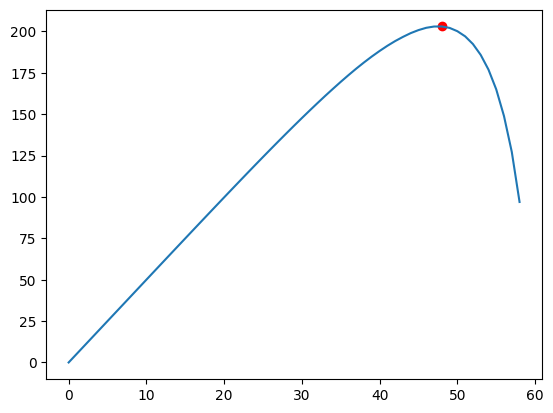

In [79]:
plt.plot(score)
drop_features=score.index(max(score))*5
best_pca=PCA(n_components=N-drop_features)
best_pca.fit(x_train_formated)

plt.scatter([drop_features/5],[np.sum(best_pca.explained_variance_ratio_*drop_features)],c='r')

print('BEST SCORE')
print('Features count:',N)
print('Drop components count:',drop_features)
print('Final featues count:', N-drop_features)
print('Press ratio:', drop_features/N)
print('Saved info:',np.sum(best_pca.explained_variance_ratio_))

<h2>Models</h2>

In [80]:
def fit_test(estimaror, param_grid,x_train,y_train,x_test,y_test,y_scaler:StandardScaler,cv=3):

    regressor=GridSearchCV(estimator=estimaror,param_grid=param_grid,cv=cv)
    regressor.fit(x_train, y_train)
    
    y_pred_train=y_scaler.inverse_transform(pd.DataFrame(regressor.predict(x_train)))
    train_mae=mean_absolute_error(y_scaler.inverse_transform(y_train), y_pred_train)
    train_r2=r2_score(y_scaler.inverse_transform(y_train), y_pred_train)


    y_pred_scale=regressor.predict(x_test)
    y_pred=y_scaler.inverse_transform(pd.DataFrame(y_pred_scale))
    test_mae=mean_absolute_error(y_test, y_pred)
    test_r2=r2_score(y_test, y_pred)

    print('Best params:', regressor.best_params_)
    print('Train MAE:', train_mae)
    print('Train R2:', train_r2)
    print('Test MAE:', test_mae)
    print('Test R2:', test_r2)

    return regressor, y_pred


<h3>Raw Linear Regrassion</h3>

In [81]:
print('Raw LinearRegression')
params={}
lasso_regressor,y_pred=fit_test(estimaror=LinearRegression(),
         param_grid=params,
         x_train=x_train_formated,
         y_train=y_train_formated,
         x_test=x_test_formated,
         y_test=y_test,
         y_scaler=y_scaler
       )

Raw LinearRegression
Best params: {}
Train MAE: 12056.893070030586
Train R2: 0.9466690086410361
Test MAE: 12435896870556.908
Test R2: -1.666830467307911e+18


<h3>Select features with Lasso</h3>

In [85]:
print('Lasso')
params={'alpha':np.linspace(0.0001,0.0003, 10)}
lasso_regressor, y_pred=fit_test(estimaror=Lasso(),
         param_grid=params,
         x_train=x_train_formated,
         y_train=y_train_formated,
         x_test=x_test_formated,
         y_test=y_test,
         y_scaler=y_scaler
       )

Lasso
Best params: {'alpha': 0.00023333333333333333}
Train MAE: 14562.009777114588
Train R2: 0.9115026783481238
Test MAE: 18266.7246860129
Test R2: 0.7896028996986689


In [86]:
coefs=pd.DataFrame(lasso_regressor.best_estimator_.coef_, x_test_formated.columns, columns=["coef"]).sort_values(by="coef", ascending=False)
coefs

,coef
GrLivArea,0.302412
OverallQual,0.103372
Neighborhood_StoneBr,0.059179
TotalBsmtSF,0.053468
BsmtFinSF1,0.050118
...,...
BsmtExposure_No,-0.008288
ExterQual_TA,-0.008716
MSSubClass,-0.010907
PoolQC_nan,-0.023793


In [87]:
t_array=np.arange(start=0,stop=0.36,step=0.002)
counts=[]
for t in t_array:
    counter=0
    for val in coefs.values: 
        if abs(val)>t:counter+=1
    counts.append(counter)

In [88]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Scatter(x=t_array, y=counts))
fig.show()

In [89]:
#also can use threshold
#t=0.001

final_num_columns=[]
for i,j in zip(coefs.index,coefs.values): 
    if abs(j)!=0:final_num_columns.append(i)

print('Selected features:')
print(final_num_columns,'\n' ,'Count:',len(final_num_columns))

Selected features:
['GrLivArea', 'OverallQual', 'Neighborhood_StoneBr', 'TotalBsmtSF', 'BsmtFinSF1', 'Neighborhood_NoRidge', 'BsmtQual_Ex', 'KitchenQual_Ex', 'OverallCond', 'Neighborhood_NridgHt', 'GarageCars', 'BsmtExposure_Gd', 'YearBuilt', 'Neighborhood_Somerst', 'BldgType_1Fam', 'SaleType_New', 'MasVnrArea', 'Neighborhood_Crawfor', 'Exterior1st_BrkFace', 'Functional_Typ', 'Fireplaces', 'YearRemodAdd', 'GarageArea', 'ExterQual_Ex', 'Condition1_Norm', 'LotConfig_CulDSac', 'LotShape_IR2', 'MSZoning_RL', 'ScreenPorch', 'FullBath', 'HalfBath', 'HeatingQC_Ex', 'SaleCondition_Normal', 'BsmtCond_TA', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Condition2_Norm', 'BsmtFinType1_GLQ', 'GarageType_BuiltIn', 'LandContour_HLS', 'RoofMatl_WdShngl', 'Exterior2nd_ImStucc', 'Fence_MnPrv', 'HouseStyle_1Story', 'Exterior2nd_VinylSd', 'BsmtFinType1_BLQ', 'Foundation_PConc', 'RoofStyle_Gable', 'BsmtCond_Fa', 'Neighborhood_OldTown', 'HeatingQC_Gd', 'Exterior2nd_Plywood', 'GarageFinish_RFn', 'BsmtQual_TA', 'Ext

<h3>LineraRegression on Lasso passed features</h3>

In [90]:
print('LinearRegression')
params={}
lasso_regressor,y_pred=fit_test(estimaror=LinearRegression(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

LinearRegression
Best params: {}
Train MAE: 14272.46134960106
Train R2: 0.9255246641512568
Test MAE: 19045.852804363763
Test R2: 0.7247060578370699


<h3>Ridge on Lasso passed features</h3>

In [91]:
print('Ridge')
params={'alpha':np.linspace(1,10, 10)}
lasso_regressor,y_pred=fit_test(estimaror=Ridge(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

Ridge
Best params: {'alpha': 1.0}
Train MAE: 14570.704430487194
Train R2: 0.9176219961076788
Test MAE: 18561.11504770169
Test R2: 0.7861243218168845


<h3>DecisionTreeRegressor on Lasso passed features</h3>

In [467]:
print('DecisionTreeRegressor')
params={'max_depth':np.arange(1,100,5)}
lasso_regressor=fit_test(estimaror=DecisionTreeRegressor(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

DecisionTreeRegressor
Best params: {'max_depth': 6}
Train MAE: 17526.75394088705
Train R2: 0.911749426172138
Test MAE: 27155.964799441907
Test R2: 0.7200954899343598


In [47]:
print('RandomForestRegressor')
params={'max_depth':np.arange(4,5,1),
        'n_estimators':np.arange(1,3,1),
        'bootstrap':[True],
        }
lasso_regressor=fit_test(estimaror=RandomForestRegressor(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

RandomForestRegressor


c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Best params: {'bootstrap': True, 'max_depth': 4, 'n_estimators': 2}
Train MAE: 19929.319423479577
Train R2: 0.8522929912667033
Test MAE: 21649.431194542696
Test R2: 0.7306849827986813


c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [98]:
print('XGBRegressor')
params={'max_depth':[2],#np.arange(1,10),
        'n_estimators':[1000],#np.arange(1,100,10),
        "objective": ["reg:squarederror"],
        "learning_rate": [0.1],#np.arange(0.1,0.2,0.1),
        "subsample": [1],#np.arange(0.9,1.1,0.1),
        "colsample_bytree":[1],#np.arange(0.5,0.6,0.1),
        "colsample_bylevel":[1],#np.arange(0.8,0.9,0.1),
        "reg_lambda":[0.1],#np.arange(0.05,0.15,0.01),
        "eval_metric": ["rmse"],
        "random_state":[1],
}

lasso_regressor=fit_test(estimaror=XGBRegressor(),
         param_grid=params,
         x_train=x_train_formated[final_num_columns],
         y_train=y_train_formated,
         x_test=x_test_formated[final_num_columns],
         y_test=y_test,
         y_scaler=y_scaler
       )

XGBRegressor


c:\Python\Lib\site-packages\xgboost\data.py:312: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Python\Lib\site-packages\xgboost\data.py:314: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:345: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:336: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:345: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:336: FutureWar

Best params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'eval_metric': 'rmse', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'random_state': 1, 'reg_lambda': 0.1, 'subsample': 1}
Train MAE: 5984.263461656066
Train R2: 0.9900338908114023
Test MAE: 15475.725224743152
Test R2: 0.9048633564032148


c:\Python\Lib\site-packages\xgboost\data.py:312: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Python\Lib\site-packages\xgboost\data.py:314: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:345: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:336: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:312: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Python\Lib\site-packages\xgboost\data.py:314: FutureWarning:

i

(array([ 1.,  0.,  0.,  1.,  1.,  0.,  1.,  2.,  1.,  3.,  2.,  5.,  3.,
         4.,  6.,  7., 12., 11., 11., 13., 21., 22., 19., 19., 10., 10.,
        10., 14., 14., 13., 17., 13., 12.,  9., 10., 10.,  7.,  9.,  9.,
         5.,  4.,  6.,  4.,  6.,  6.,  3.,  7.,  5.,  8.,  5.,  3.,  2.,
         2.,  1.,  3.,  0.,  3.,  1.,  1.,  2.,  3.,  1.,  4.,  0.,  1.,
         2.,  0.,  3.,  2.,  0.,  0.,  1.,  2.,  1.,  0.,  0.,  2.,  3.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 36123.73046875,  40706.9609375 ,  45290.19140625,  49873.41796875,
         54456.6484375 ,  59039.87890625,  63623.109375  ,  68206.3359375 ,
         72789.5703125 ,  77372.796875  ,  81956.0234375 ,  86539.2578125 ,
         91122.484375  ,  95705.71875   , 100288.9453125 , 104872.171875  ,
        109455.40625   , 114038.6328125 , 118621.859375  , 123205.09375   ,
        127788.3203125 , 132371.546875  , 136954.78125

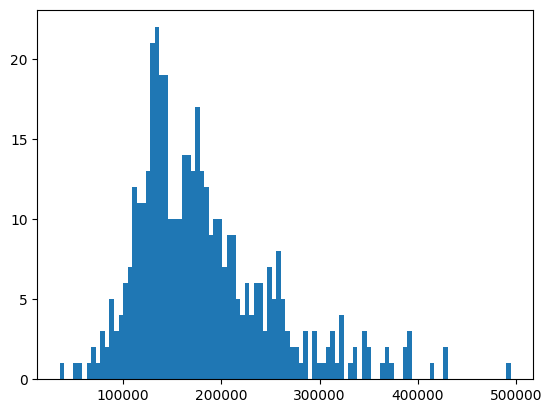

In [504]:
plt.hist(lasso_regressor[1],bins=100)

<h2>Make predictions</h2>

In [29]:
test_df=pd.read_csv('data/test.csv')

In [71]:
y_train=df['SalePrice']
x_train=df.drop(columns=['SalePrice','Id'])

x_test=test_df.drop(columns=['Id'])


num_fillna=lambda x:0
num_scaler=StandardScaler()
obj_formater=OneHotEncoder(handle_unknown='infrequent_if_exist')
pca_n_components=0
y_scaler=StandardScaler()

x_train_formated,num_scaler,obj_formater,pca_formater,encode_columns=preproc_x_train(x_train,num_fillna,num_scaler,obj_formater,pca_n_components)
x_test_formated=preproc_x_test(x_test,num_fillna,num_scaler,obj_formater,pca_formater,encode_columns)
y_train_formated,y_scaler=preprocess_y_train(pd.DataFrame(y_train),y_scaler)

In [72]:
params={'max_depth':2,
        'n_estimators':1000,
        "objective": "reg:squarederror",
        "learning_rate": 0.1,
        "subsample": 1,
        "colsample_bytree":0.5,
        "colsample_bylevel":0.8,
        "reg_lambda":0.1,
        "eval_metric": "rmse",
        "random_state":1
}

regresssor=XGBRegressor(**params)
regresssor.fit(x_train_formated[final_num_columns],y_train_formated)
y_pred_scaled=pd.DataFrame(regresssor.predict(x_test_formated[final_num_columns]))
y_pred=y_scaler.inverse_transform(y_pred_scaled)
saleprice=pd.DataFrame(y_pred,columns=['SalePrice'])
saleprice.index=range(1461,2920)
saleprice.to_csv('answer.csv')

c:\Python\Lib\site-packages\xgboost\data.py:312: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Python\Lib\site-packages\xgboost\data.py:314: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:345: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:336: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:345: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Python\Lib\site-packages\xgboost\data.py:336: FutureWar

In [ ]:
saleprice.index